In [2]:
import csv
import os

import numpy as np
import pandas as pd
#from owid_downloader import GenerateTrainingData
#from utils import date_today, gravity_law_commute_dist

os.environ['NUMEXPR_MAX_THREADS'] = '16'
os.environ['NUMEXPR_NUM_THREADS'] = '8'

import pickle
import matplotlib.pyplot as plt
import dgl
import torch
from torch import nn
import torch.nn.functional as F
from model import STAN

import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

Using backend: pytorch


In [3]:
#GenerateTrainingData().download_jhu_data('2020-08-01', '2020-12-01')
start_date = '2021-01-01'
end_date = '2021-05-31'

In [4]:
# data processing
raw_data = pd.read_csv('owid-covid-data.csv', usecols=["location", "date", "total_cases", "new_cases_smoothed", "total_deaths",
                    "new_deaths", "total_vaccinations", "people_fully_vaccinated", "new_vaccinations", "population"])
raw_data['date'] = pd.to_datetime(raw_data['date'])
mask = (raw_data['date'] >= start_date) & (raw_data['date'] <= end_date) # & (raw_data['location'].isin(countries))
raw_data = raw_data.loc[mask]
#print(raw_data[raw_data['location'] == 'United States']['total_cases'].values[0])
countries = []
loc_list = list(raw_data['location'].unique())
# only include countries that have more than 1000 total cases on start date and at least 1 death
for loc in loc_list:
    if raw_data[raw_data['location'] == loc]["total_cases"].values[0] > 1000 and \
        raw_data[raw_data['location'] == loc]["total_deaths"].values[0] > 0:
        countries.append(loc)
# hard-coded; these are problematic locations (non-countries) that need to be removed
countries.remove("European Union")
countries.remove("Europe")
countries.remove("Africa")
countries.remove("Asia")
countries.remove("North America")
countries.remove("Oceania")
countries.remove("South America")
countries.remove("World")
countries.remove("Tajikistan")
mask = raw_data['location'].isin(countries)
raw_data = raw_data.loc[mask]
print(len(raw_data['location'].unique()))

163


In [6]:
# Generate Graph
# add flight neighbors
# for now, add a connection if there is any flight between the two countries between start and end date
loc_list = list(raw_data['location'].unique())
flight_counts = pd.read_csv('processed_flights/flight_counts_2021_all.csv')
adj_map = {}
for each_loc in loc_list:
    df = flight_counts.loc[flight_counts["origin_country"] == each_loc]
    adj_map[each_loc] = set(df["destination_country"].unique())
flight_counts['day'] = pd.to_datetime(flight_counts['day'])

In [7]:
# add land neighbors
import csv
neighbor_reader = csv.reader(open('neighbors.csv', 'r'))
neighbors = {}
for row in neighbor_reader:
   neighbors[row[0]] = row[1].split(',')
for each_loc,connected in adj_map.items():
    for neighbor in neighbors[each_loc]:
        if neighbor in loc_list:
            connected.add(neighbor)

In [8]:
# create graph
rows = []
cols = []
for each_loc in adj_map:
    for each_loc2 in adj_map[each_loc]:
        if each_loc in loc_list and each_loc2 in loc_list:
            rows.append(loc_list.index(each_loc))
            cols.append(loc_list.index(each_loc2))
#print(rows)
#print(cols)
g = dgl.graph((rows, cols))
print(g.number_of_nodes)

<bound method DGLHeteroGraph.number_of_nodes of Graph(num_nodes=163, num_edges=3765,
      ndata_schemes={}
      edata_schemes={})>


In [9]:
# import networkx as nx
# nx_g = g.to_networkx()
# pos = nx.kamada_kawai_layout(nx_g)
# plt.figure(1,figsize=(8,8)) 
# nx.draw(nx_g, pos, with_labels=True, node_color=[[.7, .7, .7]])
# plt.show()

In [10]:
#Preprocess features

#active_cases = []
confirmed_cases = []
new_cases = []
new_vaccinations = []
fully_vaccinated = []
death_cases = []
static_feat = []

for i, each_loc in enumerate(loc_list):
    confirmed_cases.append(raw_data[raw_data['location'] == each_loc]['total_cases'])
    new_cases.append(raw_data[raw_data['location'] == each_loc]['new_cases_smoothed'])
    new_vaccinations.append(raw_data[raw_data['location'] == each_loc]['new_vaccinations'])
    fully_vaccinated.append(raw_data[raw_data['location'] == each_loc]['people_fully_vaccinated'])
    death_cases.append(raw_data[raw_data['location'] == each_loc]['total_deaths'])
    static_feat.append(np.array(raw_data[raw_data['location'] == each_loc][['population']]))
confirmed_cases = np.nan_to_num(np.array(confirmed_cases))
death_cases = np.nan_to_num(np.array(death_cases)[:, 14:])
new_cases = np.nan_to_num(np.array(new_cases)[:, 14:])
new_vaccinations = np.nan_to_num(np.array(new_vaccinations)[:, 14:])
fully_vaccinated = np.nan_to_num(np.array(fully_vaccinated))
static_feat = np.nan_to_num(np.array(static_feat)[:, 0, :])

import copy
# active = confirmed(today) - confirmed(14 days ago)
cases_copy = copy.deepcopy(confirmed_cases)
active = []
for loc in confirmed_cases:
    active_loc = []
    for i in range(14, len(loc)):
        active_loc.append(loc[i] - loc[i-14])
    active.append(active_loc)
active_cases = np.array(active)

confirmed_cases = confirmed_cases[:, 14:]
fully_vaccinated = fully_vaccinated[:, 14:]

recovered_cases = confirmed_cases - active_cases - death_cases + 0.94*fully_vaccinated
susceptible_cases = np.expand_dims(static_feat[:, 0], -1) - active_cases - recovered_cases

# Batch_feat: new_cases(dI), dR, dS
#dI = np.array(new_cases)
dI = np.concatenate((np.zeros((active_cases.shape[0],1), dtype=np.float32), np.diff(active_cases)), axis=-1)
dR = np.concatenate((np.zeros((recovered_cases.shape[0],1), dtype=np.float32), np.diff(recovered_cases)), axis=-1)
dS = np.concatenate((np.zeros((susceptible_cases.shape[0],1), dtype=np.float32), np.diff(susceptible_cases)), axis=-1)
# number of new fully vaccinated each day
Vt = np.concatenate((np.zeros((fully_vaccinated.shape[0],1), dtype=np.float32), np.diff(fully_vaccinated)), axis=-1)
print("done")

done


In [11]:
#Build normalizer
normalizer = {'S':{}, 'I':{}, 'R':{}, 'dS':{}, 'dI':{}, 'dR':{}, 'Vt':{}}

for i, each_loc in enumerate(loc_list):
    normalizer['S'][each_loc] = (np.mean(susceptible_cases[i]), np.std(susceptible_cases[i]))
    normalizer['I'][each_loc] = (np.mean(active_cases[i]), np.std(active_cases[i]))
    normalizer['R'][each_loc] = (np.mean(recovered_cases[i]), np.std(recovered_cases[i]))
    normalizer['dI'][each_loc] = (np.mean(dI[i]), np.std(dI[i]))
    normalizer['dR'][each_loc] = (np.mean(dR[i]), np.std(dR[i]))
    normalizer['dS'][each_loc] = (np.mean(dS[i]), np.std(dS[i]))
    normalizer['Vt'][each_loc] = (np.mean(Vt[i]), np.std(Vt[i]))

In [12]:
def prepare_data(data, sum_I, sum_R, Vt, edges_df, start, history_window=5, pred_window=15, slide_step=5):
    # Data shape n_loc, timestep, n_feat
    # Reshape to n_loc, t, history_window*n_feat
    n_loc = data.shape[0]
    timestep = data.shape[1]
    n_feat = data.shape[2]
    
    x = []
    y_I = []
    y_R = []
    last_I = []
    last_R = []
    concat_I = []
    concat_R = []
    concat_Vt = []
    edges = []
    for i in range(0, timestep, slide_step):
        if i+history_window+pred_window-1 >= timestep or i+history_window >= timestep:
            break
        x.append(data[:, i:i+history_window, :].reshape((n_loc, history_window*n_feat)))
        
        concat_I.append(data[:, i+history_window-1, 0])
        concat_R.append(data[:, i+history_window-1, 1])
        last_I.append(sum_I[:, i+history_window-1])
        last_R.append(sum_R[:, i+history_window-1])

        y_I.append(data[:, i+history_window:i+history_window+pred_window, 0])
        y_R.append(data[:, i+history_window:i+history_window+pred_window, 1])

        concat_Vt.append(Vt[:, i+history_window:i+history_window+pred_window])
        
        e_matrix = np.zeros((n_loc, n_loc)) # edge weight matrix for every time period 
        df = edges_df.groupby(["origin_country"])
        for loc in range(n_loc):
            try:
                src_df = df.get_group(loc_list[loc])
                src_df = src_df.groupby(["destination_country"])
                for loc2 in range(n_loc):
                    try:
                        dst_df = src_df.get_group(loc_list[loc2])
                        dst_df = dst_df.loc[(dst_df['day'] >= (pd.to_datetime(start) + pd.DateOffset(days=i)))]
                        dst_df = dst_df.loc[(dst_df['day'] < (pd.to_datetime(start) + pd.DateOffset(days=i+history_window-1)))]
                        e_matrix[loc, loc2] = dst_df['flight_count'].sum()
                    except:
                        continue
            except:
                continue
        # normalize matrix (doubly stochastic, see https://arxiv.org/pdf/1809.02709.pdf)
        # step 1: row normalize
        norm = np.sum(e_matrix, axis=1, keepdims=True)
        norm[norm==0] = 1e-10
        norm = 1.0 / norm
        P = e_matrix * norm

        # step 2: P @ P^T / column_norm
        norm = np.sum(P, axis=0, keepdims=True)
        norm[norm==0] = 1e-10
        norm = 1.0 / norm

        PT = np.transpose(P, (1, 0))
        P = np.multiply(P, norm)
        T = np.matmul(P, PT)
        edges.append(T) # n_rows = # countries, n_cols = # countries
        
    
    x = np.array(x, dtype=np.float32).transpose((1, 0, 2))
    last_I = np.array(last_I, dtype=np.float32).transpose((1, 0))
    last_R = np.array(last_R, dtype=np.float32).transpose((1, 0))
    concat_I = np.array(concat_I, dtype=np.float32).transpose((1, 0))
    concat_R = np.array(concat_R, dtype=np.float32).transpose((1, 0))
    y_I = np.array(y_I, dtype=np.float32).transpose((1, 0, 2))
    y_R = np.array(y_R, dtype=np.float32).transpose((1, 0, 2))
    concat_Vt = np.array(concat_Vt, dtype=np.float32).transpose((1, 0, 2))
    return x, last_I, last_R, concat_I, concat_R, y_I, y_R, concat_Vt, edges

In [13]:
import time
start_time = time.time()
# re-run from here
valid_window = 25
test_window = 25

history_window=7 # one week
pred_window=15
slide_step=6

dynamic_feat = np.concatenate((np.expand_dims(dI, axis=-1), np.expand_dims(dR, axis=-1), np.expand_dims(dS, axis=-1)), axis=-1)
    
#Normalize
for i, each_loc in enumerate(loc_list):
    dynamic_feat[i, :, 0] = (dynamic_feat[i, :, 0] - normalizer['dI'][each_loc][0]) / normalizer['dI'][each_loc][1]
    dynamic_feat[i, :, 1] = (dynamic_feat[i, :, 1] - normalizer['dR'][each_loc][0]) / normalizer['dR'][each_loc][1]
    dynamic_feat[i, :, 2] = (dynamic_feat[i, :, 2] - normalizer['dS'][each_loc][0]) / normalizer['dS'][each_loc][1]
    # vaccinations don't need to be normalized
    #mean_vax = normalizer['Vt'][each_loc][0]
    #if mean_vax != 0:
    #   Vt[i] = (Vt[i] - mean_vax) / normalizer['Vt'][each_loc][1]
dI_mean = []
dI_std = []
dR_mean = []
dR_std = []

for i, each_loc in enumerate(loc_list):
    dI_mean.append(normalizer['dI'][each_loc][0])
    dR_mean.append(normalizer['dR'][each_loc][0])
    dI_std.append(normalizer['dI'][each_loc][1])
    dR_std.append(normalizer['dR'][each_loc][1])

dI_mean = np.array(dI_mean)
dI_std = np.array(dI_std)
dR_mean = np.array(dR_mean)
dR_std = np.array(dR_std)

#Split train-test
train_feat = dynamic_feat[:, :-valid_window-test_window, :]
val_feat = dynamic_feat[:, -valid_window-test_window:-test_window, :]
test_feat = dynamic_feat[:, -test_window:, :]

valid_start_date = pd.to_datetime(end_date) + pd.DateOffset(days=-valid_window) + pd.DateOffset(days=-test_window)
test_start_date = pd.to_datetime(end_date) + pd.DateOffset(days=-test_window)

train_edges = flight_counts[(flight_counts["day"] >= start_date) & (flight_counts["day"] < valid_start_date)]
val_edges = flight_counts[(flight_counts["day"] >= valid_start_date) & (flight_counts["day"] < test_start_date)]
test_edges = flight_counts[(flight_counts["day"] >= test_start_date) & (flight_counts["day"] < end_date)]

train_x, train_I, train_R, train_cI, train_cR, train_yI, train_yR, train_Vt, train_edges = prepare_data(train_feat, active_cases[:, :-valid_window-test_window], recovered_cases[:, :-valid_window-test_window], Vt[:, :-valid_window-test_window], train_edges, start_date, history_window, pred_window, slide_step)

val_x, val_I, val_R, val_cI, val_cR, val_yI, val_yR, val_Vt, val_edges = prepare_data(val_feat, active_cases[:, -valid_window-test_window:-test_window], recovered_cases[:, -valid_window-test_window:-test_window], Vt[:, -valid_window-test_window:-test_window], val_edges, valid_start_date, history_window, pred_window, slide_step)

test_x, test_I, test_R, test_cI, test_cR, test_yI, test_yR, test_Vt, test_edges = prepare_data(test_feat, active_cases[:, -test_window:], recovered_cases[:, -test_window:], Vt[:, -test_window:], test_edges, test_start_date, history_window, pred_window, slide_step)
print("--- %s seconds ---" % (time.time() - start_time)) # a minute or two, depending on date/window lengths

--- 89.94962072372437 seconds ---


In [14]:
print(np.array(train_edges).shape) # one matrix for each timestep
print(train_x.shape) # one array of features for each timestep for each location
print(np.array(val_edges).shape)
print(val_x.shape)
print(np.array(test_edges).shape)
print(test_x.shape)

#print(train_edges[0][155]) # first timestep of training, 155=United States row

(11, 163, 163)
(163, 11, 21)
(1, 163, 163)
(163, 1, 21)
(1, 163, 163)
(163, 1, 21)


In [15]:
#Build STAN model

in_dim = 3*history_window
hidden_dim1 = 32
hidden_dim2 = 32
gru_dim = 32
num_heads = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

g = g.to(device)
model = STAN(g, in_dim, hidden_dim1, hidden_dim2, gru_dim, num_heads, pred_window, device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss()

In [16]:
model

STAN(
  (layer1): MultiHeadGATLayer(
    (heads): ModuleList(
      (0): GATLayer(
        (fc): Linear(in_features=21, out_features=32, bias=True)
        (attn_fc): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
  (layer2): MultiHeadGATLayer(
    (heads): ModuleList(
      (0): GATLayer(
        (fc): Linear(in_features=32, out_features=32, bias=True)
        (attn_fc): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
  (gru): GRUCell(32, 32)
  (nn_res_I): Linear(in_features=34, out_features=15, bias=True)
  (nn_res_R): Linear(in_features=34, out_features=15, bias=True)
  (nn_res_sir): Linear(in_features=34, out_features=3, bias=True)
)

In [17]:
train_x = torch.tensor(train_x).to(device)
train_I = torch.tensor(train_I).to(device)
train_R = torch.tensor(train_R).to(device)
train_cI = torch.tensor(train_cI).to(device)
train_cR = torch.tensor(train_cR).to(device)
train_yI = torch.tensor(train_yI).to(device)
train_yR = torch.tensor(train_yR).to(device)
train_Vt = torch.tensor(train_Vt).to(device)
train_edges = torch.tensor(train_edges).to(device)

val_x = torch.tensor(val_x).to(device)
val_I = torch.tensor(val_I).to(device)
val_R = torch.tensor(val_R).to(device)
val_cI = torch.tensor(val_cI).to(device)
val_cR = torch.tensor(val_cR).to(device)
val_yI = torch.tensor(val_yI).to(device)
val_yR = torch.tensor(val_yR).to(device)
val_Vt = torch.tensor(val_Vt).to(device)
val_edges = torch.tensor(val_edges).to(device)

test_x = torch.tensor(test_x).to(device)
test_I = torch.tensor(test_I).to(device)
test_R = torch.tensor(test_R).to(device)
test_cI = torch.tensor(test_cI).to(device)
test_cR = torch.tensor(test_cR).to(device)
test_yI = torch.tensor(test_yI).to(device)
test_yR = torch.tensor(test_yR).to(device)
test_Vt = torch.tensor(test_Vt).to(device)
test_edges = torch.tensor(test_edges).to(device)

dI_mean = torch.tensor(dI_mean, dtype=torch.float32).to(device).reshape((dI_mean.shape[0], 1, 1))
dI_std = torch.tensor(dI_std, dtype=torch.float32).to(device).reshape((dI_mean.shape[0], 1, 1))
dR_mean = torch.tensor(dR_mean, dtype=torch.float32).to(device).reshape((dI_mean.shape[0], 1, 1))
dR_std = torch.tensor(dR_std, dtype=torch.float32).to(device).reshape((dI_mean.shape[0], 1, 1))

N = torch.tensor(static_feat[:, 0], dtype=torch.float32).to(device).unsqueeze(-1)

In [18]:
#Train STAN
all_loss = []
file_name = './save/stan'
min_loss = 1e10

loc_name = 'United States'
cur_loc = loc_list.index(loc_name)

for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    
    active_pred, recovered_pred, phy_active, phy_recover, _ = model(train_x, train_cI[cur_loc], train_cR[cur_loc], N[cur_loc], train_I[cur_loc], train_R[cur_loc], V=train_Vt[cur_loc], e_weights=train_edges)
    phy_active = (phy_active - dI_mean[cur_loc]) / dI_std[cur_loc]
    phy_recover = (phy_recover - dR_mean[cur_loc]) / dR_std[cur_loc]
    loss = criterion(active_pred.squeeze(), train_yI[cur_loc].squeeze())+criterion(recovered_pred.squeeze(), train_yR[cur_loc].squeeze())+0.1*criterion(phy_active.squeeze(), train_yI[cur_loc].squeeze())+0.1*criterion(phy_recover.squeeze(), train_yR[cur_loc].squeeze())
    
    loss.backward()
    optimizer.step()
    all_loss.append(loss.item())
    
    model.eval()
    _, _, _, _, prev_h = model(train_x, train_cI[cur_loc], train_cR[cur_loc], N[cur_loc], train_I[cur_loc], train_R[cur_loc], V=train_Vt[cur_loc], e_weights=train_edges)
    val_active_pred, val_recovered_pred, val_phy_active, val_phy_recover, _ = model(val_x, val_cI[cur_loc], val_cR[cur_loc], N[cur_loc], val_I[cur_loc], val_R[cur_loc], prev_h, V=val_Vt[cur_loc], e_weights=val_edges)
    
    val_phy_active = (val_phy_active - dI_mean[cur_loc]) / dI_std[cur_loc]
    val_loss = criterion(val_active_pred.squeeze(), val_yI[cur_loc].squeeze()) + 0.1*criterion(val_phy_active.squeeze(), val_yI[cur_loc].squeeze())
    if val_loss < min_loss:    
        state = {
            'state': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        torch.save(state, file_name)
        min_loss = val_loss
        print('-----Save best model-----')
    
    print('Epoch %d, Loss %.2f, Val loss %.2f'%(epoch, all_loss[-1], val_loss.item()))

-----Save best model-----
Epoch 0, Loss 69611.61, Val loss 10076.19
-----Save best model-----
Epoch 1, Loss 15701.49, Val loss 2155.17
-----Save best model-----
Epoch 2, Loss 3956.43, Val loss 710.56
-----Save best model-----
Epoch 3, Loss 1142.59, Val loss 414.48
-----Save best model-----
Epoch 4, Loss 718.44, Val loss 203.69
-----Save best model-----
Epoch 5, Loss 466.30, Val loss 136.09
Epoch 6, Loss 296.20, Val loss 138.60
-----Save best model-----
Epoch 7, Loss 197.70, Val loss 77.66
-----Save best model-----
Epoch 8, Loss 119.76, Val loss 53.43
Epoch 9, Loss 44.28, Val loss 58.51
-----Save best model-----
Epoch 10, Loss 36.00, Val loss 25.92
-----Save best model-----
Epoch 11, Loss 21.87, Val loss 19.38
Epoch 12, Loss 23.06, Val loss 25.80
Epoch 13, Loss 12.69, Val loss 23.41
-----Save best model-----
Epoch 14, Loss 14.36, Val loss 14.83
Epoch 15, Loss 9.22, Val loss 14.95
-----Save best model-----
Epoch 16, Loss 11.91, Val loss 9.34
-----Save best model-----
Epoch 17, Loss 8.43,

In [20]:
#Pred with STAN
file_name = './save/stan'
checkpoint = torch.load(file_name)
model.load_state_dict(checkpoint['state'])
optimizer.load_state_dict(checkpoint['optimizer'])
model.eval()


prev_x = torch.cat((train_x, val_x), dim=1)
prev_I = torch.cat((train_I, val_I), dim=1)
prev_R = torch.cat((train_R, val_R), dim=1)
prev_cI = torch.cat((train_cI, val_cI), dim=1)
prev_cR = torch.cat((train_cR, val_cR), dim=1)
prev_Vt = torch.cat((train_Vt, val_Vt), dim=1)
prev_edges = torch.cat((train_edges, val_edges), dim=0)
prev_active_pred, _, prev_phyactive_pred, _, h = model(prev_x, prev_cI[cur_loc], prev_cR[cur_loc], N[cur_loc], prev_I[cur_loc], prev_R[cur_loc], V=prev_Vt[cur_loc], e_weights=prev_edges)


test_pred_active, test_pred_recovered, test_pred_phy_active, test_pred_phy_recover, _ = model(test_x, test_cI[cur_loc], test_cR[cur_loc], N[cur_loc], test_I[cur_loc], test_R[cur_loc], h, V=test_Vt[cur_loc], e_weights=test_edges)

In [21]:
print('Estimated beta in SIR model is %.2f'%model.alpha_scaled)
print('Estimated gamma in SIR model is %.2f'%model.beta_scaled)
print('Estimated theta in SIR model is %.2f'%model.theta_scaled)

Estimated beta in SIR model is 0.03
Estimated gamma in SIR model is 0.44
Estimated theta in SIR model is 0.07


In [22]:
#Cumulate predicted dI
pred_I = []
sir_I = []

for i in range(test_pred_active.size(1)):
    # below is regular prediction
    cur_pred = (test_pred_active[0, i, :].detach().cpu().numpy() * dI_std[cur_loc].reshape(1, 1).detach().cpu().numpy()) + dI_mean[cur_loc].reshape(1, 1).detach().cpu().numpy()
    # below is SIR model prediction
    sir_pred = test_pred_phy_active[0, i, :].detach().cpu().numpy()
    # below is average of the two predictions
    #cur_pred = (cur_pred + test_pred_phy_active[0, i, :].detach().cpu().numpy()) / 2
    cur_pred = np.cumsum(cur_pred)
    cur_pred = cur_pred + test_I[cur_loc, i].detach().cpu().item()
    pred_I.append(cur_pred)

    sir_pred = np.cumsum(sir_pred)
    sir_pred = sir_pred + test_I[cur_loc, i].detach().cpu().item()
    sir_I.append(sir_pred)
pred_I = np.array(pred_I)
sir_I = np.array(sir_I)

In [23]:
def get_real_y(data, history_window=5, pred_window=15, slide_step=5):
    # Data shape n_loc, timestep, n_feat
    # Reshape to n_loc, t, history_window*n_feat
    n_loc = data.shape[0]
    timestep = data.shape[1]
    
    y = []
    for i in range(0, timestep, slide_step):
        if i+history_window+pred_window-1 >= timestep or i+history_window >= timestep:
            break
        y.append(data[:, i+history_window:i+history_window+pred_window])
    y = np.array(y, dtype=np.float32).transpose((1, 0, 2))
    return y

In [24]:
I_true = get_real_y(active_cases[:], history_window, pred_window, slide_step)

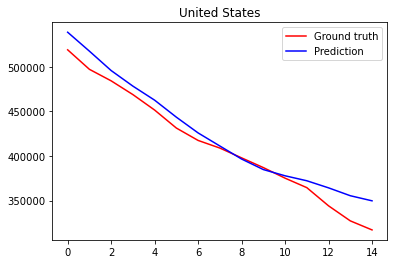

In [25]:
plt.plot(I_true[cur_loc, -1, :],c='r', label='Ground truth')
plt.plot(pred_I[-1, :],c='b', label='Prediction')
#plt.plot(sir_I[-1, :],c='purple', label='SIR Prediction')
plt.legend()
plt.title(loc_name)
plt.show()